# 3-a: Bayesian Linear Regression

During this session, we will work with Bayesian Linear Regression models with varying basis functions (linear, polynomial and Gaussian). Datasets used are 1D toy regression samples ranging from linear datasets to more complex non-linear datasets such as increasing sinusoidal curves.

**Goal**: Take hand on simple Bayesian models, understand how it works, gain finer insights on predictive distribution.



# Introduction
Bayesian Linear Regression *(BLR)* is a cornerstone technique in Bayesian modeling, providing a probabilistic framework to tackle uncertainty in data.

We have hence delved into BLR in this project, focusing on practical applications, in particular on the estimation of predictive distributions and understanding model uncertainty. The practical sessions offered a comprehensive and understanding model uncertainty. The practical sessions offered a comprehensive investigation into the role of prior knowledge, basis functions, and their influence on predictive variance and model performance.

The final goal of this work was to evaluate BLR's performance under various configurations of basis functions and training data distributions. We started with simple linear basis functions to understand BLR in its most fundamental form. This provided a foundational understanding of how prior assumptions and data combine to form a posterior distribution over model parameters. Subsequently, the project progressed to polynomial and Gaussian basis functions to explore BLR's adaptablity to non-linear data and localized feature representation. Each practical was designd to highlight a specific aspect of BLR's capabilities, such as posterior evolution with increasing data, predictive variance behavior, and the impact of basis function selection.

The results revealed BLR's strenghts and limitations:
- **Linear Basis Functions:** Ideal for datasets with linear relationships, showing low predictive variance within the training region but high variance when extrapolating.
- **Polynomial Basis Functions:** Allowed the model to capture non-linear trends but amplified uncertainty in extrapolation, highlighting the risk of overfitting.
- **Gaussian Basis Functions:** Demonstrated localized representation, effectively modeling non-linear patterns while maintaining controlled predictive v

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Useful function: plot results
def plot_results(X_train, y_train, X_test, y_test, y_pred, std_pred,
                 xmin=-2, xmax=2, ymin=-2, ymax=1, stdmin=0.30, stdmax=0.45):
    """Given a dataset and predictions on test set, this function draw 2 subplots:
    - left plot compares train set, ground-truth (test set) and predictions
    - right plot represents the predictive variance over input range

    Args:
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      X_test: (array) test inputs, sized [N,]
      y_test: (array) test labels, sized [N, ]
      y_pred: (array) mean prediction, sized [N, ]
      std_pred: (array) std prediction, sized [N, ]
      xmin: (float) min value for x-axis on left and right plot
      xmax: (float) max value for x-axis on left and right plot
      ymin: (float) min value for y-axis on left plot
      ymax: (float) max value for y-axis on left plot
      stdmin: (float) min value for y-axis on right plot
      stdmax: (float) max value for y-axis on right plot

    Returns:
      None
    """
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = ymin, ymax = ymax)
    plt.plot(X_test, y_test, color='green', linewidth=2,
             label="Ground Truth")
    plt.plot(X_train, y_train, 'o', color='blue', label='Training points')
    plt.plot(X_test, y_pred, color='red', label="BLR Poly")
    plt.fill_between(X_test, y_pred-std_pred, y_pred+std_pred, color='indianred', label='1 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*2, y_pred-std_pred, color='lightcoral')
    plt.fill_between(X_test, y_pred+std_pred*1, y_pred+std_pred*2, color='lightcoral', label='2 std. int.')
    plt.fill_between(X_test, y_pred-std_pred*3, y_pred-std_pred*2, color='mistyrose')
    plt.fill_between(X_test, y_pred+std_pred*2, y_pred+std_pred*3, color='mistyrose', label='3 std. int.')
    plt.legend()

    plt.subplot(122)
    plt.title("Predictive variance along x-axis")
    plt.xlim(xmin = xmin, xmax = xmax)
    plt.ylim(ymin = stdmin, ymax = stdmax)
    plt.plot(X_test, std_pred**2, color='red', label="\u03C3² {}".format("Pred"))

    # Get training domain
    training_domain = []
    current_min = sorted(X_train)[0]
    for i, elem in enumerate(sorted(X_train)):
        if elem-sorted(X_train)[i-1]>1:
            training_domain.append([current_min,sorted(X_train)[i-1]])
            current_min = elem
    training_domain.append([current_min, sorted(X_train)[-1]])

    # Plot domain
    for j, (min_domain, max_domain) in enumerate(training_domain):
        plt.axvspan(min_domain, max_domain, alpha=0.5, color='gray', label="Training area" if j==0 else '')
    plt.axvline(X_train.mean(), linestyle='--', label="Training barycentre")

    plt.legend()
    plt.show()

## Part I: Linear Basis function model

We start with a linear dataset where we will analyze the behavior of linear basis functions in the framework of Bayesian Linear Regression.

In [ ]:
# Generate linear toy dataset
def f_linear(x, noise_amount, sigma):
    y = -0.3 + 0.5*x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount*noise

# Create training and test points
sigma = 0.2
nbpts=25
dataset_linear = {}
dataset_linear['X_train'] = np.random.uniform(0, 2, nbpts)
dataset_linear['y_train'] = f_linear(dataset_linear['X_train'], noise_amount=1, sigma=sigma)
dataset_linear['X_test'] = np.linspace(-10,10, 10*nbpts)
dataset_linear['y_test'] = f_linear(dataset_linear['X_test'], noise_amount=0, sigma=sigma)

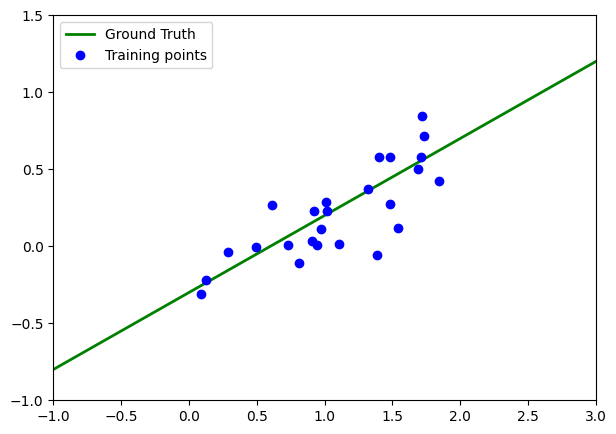

In [ ]:
# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmax = 3, xmin =-1)
plt.ylim(ymax = 1.5, ymin = -1)
plt.plot(dataset_linear['X_test'], dataset_linear['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_linear['X_train'], dataset_linear['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

In [ ]:
# Hyperparameters
dataset_linear['ALPHA'] = 2.0
dataset_linear['BETA'] = 1/(2.0*sigma**2)

We will use the linear basis function:
    $\phi:x \rightarrow (1,x)$

Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 \\
    ... & ...\\
    1 & x_n
  \end{bmatrix}
$$

**Question 1.1: Code linear basis function**

In [ ]:
#TO DO: Define basis function

def phi_linear(x):
    """ Linear Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) linear features of x
    """

    return np.column_stack((np.ones(len(x)), x))

array = phi_linear(dataset_linear['X_train'])

**Question 1.2: Recall closed form of the posterior distribution in linear case. Then, code and visualize posterior sampling. What can you observe?**

In Bayesian Linear Regression, the posterior distribution of the weights $w$ given the training data $D = \{X, y\}$ is:

$$p(w \mid X, y, \alpha, \beta) = \mathcal{N}(w \mid \mu_N, \Sigma_N)$$

Where:
- $\mu_N$ is the posterior mean.
- $\Sigma_N$ is the posterior covariance.

The closed-form solutions are as follows:

- **Posterior Covariance:**
   $\Sigma_N = \left( \alpha \cdot I + \beta \cdot \Phi^T \cdot \Phi \right)^{-1}$

- **Posterior Mean:**
   $\mu_N = \beta \cdot \Sigma_N \cdot \Phi^T \cdot y$



<ipython-input-7-7ecaee4ff9c7>:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )


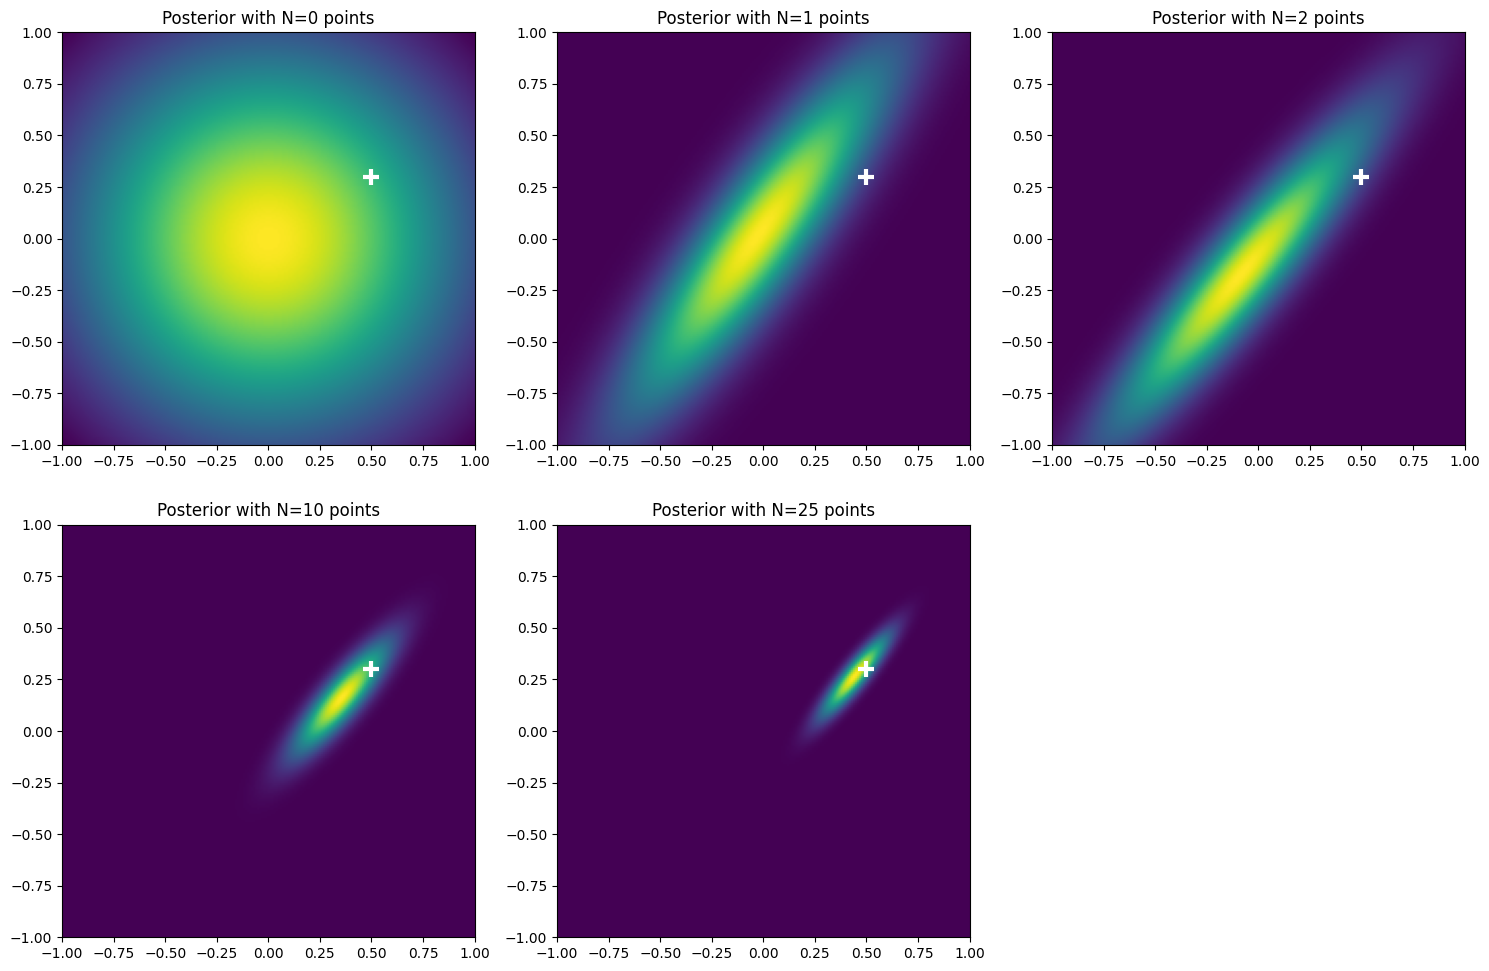

In [ ]:
#TO DO: Code and visualize posterior sampling by completing code below

plt.figure(figsize=(15,10))
for count,n in enumerate([0,1,2,10,len(dataset_linear['X_train'])]):
    cur_data = dataset_linear['X_train'][:n]
    cur_lbl = dataset_linear['y_train'][:n]
    meshgrid = np.arange(-1, 1.01, 0.01)
    w = np.zeros((2,1))
    posterior = np.zeros((meshgrid.shape[0],meshgrid.shape[0]))

    # TO DO: code mu_n and sigma_N
    phi = phi_linear(cur_data)
    alpha = dataset_linear['ALPHA']
    beta = dataset_linear['BETA']
    sigma_N = np.linalg.inv(alpha*np.eye(2) + beta * phi.T @phi)
    mu_N = beta*sigma_N@phi.T@cur_lbl

    # Compute values on meshgrid
    for i in range(meshgrid.shape[0]):
        for j in range(meshgrid.shape[0]):
            w[0,0] = meshgrid[i]
            w[1,0] = meshgrid[j]
            posterior[i,j] = np.exp(-0.5* np.dot(np.dot((w-mu_N.reshape(2,1)).T, np.linalg.inv(sigma_N)) , (w-mu_N.reshape(2,1)) ) )
    Z = 1.0 / ( np.sqrt(2*np.pi* np.linalg.det(sigma_N) ) )
    posterior[:,:] /= Z

    # Plot posterior with n points
    plt.subplot(231+count)
    plt.imshow(posterior, extent=[-1,1,-1,1])
    plt.plot(0.5,0.3, '+', markeredgecolor='white', markeredgewidth=3, markersize=12)
    plt.title('Posterior with N={} points'.format(n))
plt.tight_layout()
plt.show()

#### Observations
**Posterior Evolution with increasing data points**

With no data (N=0), the posterior reflects only the prior. It's in fact centered at [0,0], with large uncertainty (broad distribution). As data points are added, the posterior narrows, indicatinf reduced uncertainty in the parametere estimates.
The posterior mean ($\mu _N)$ moves toward the true values [0.5, 0.3]

**Role of the prior**

As we have seen the role of the prior is completely different, depending on N.
- for small N, the prior significantly influences the posterior.
- for large N instead, the influence of the prior diminishes, since the likelihood dominates.

Hence we can say that more data points lead to higher certainty (smaller posterior variance) and better convergence to the mean.

**Question 1.3: Recall and code closed form of the predictive distribution in linear case.**


In Bayesian Linear Regression, the predictive distribution for a new input $x^*$ is a Gaussian distribution:

$$p(y \mid x^*, X, y, \alpha, \beta) = \mathcal{N}(y \mid \mu_{pred}, \sigma_{pred}^2)$$

Where:
- $\mu_{pred}$ is the mean of predictive distribution.
- $\sigma_{pred}^2$ is the variance of predictive distribution.

The closed-form solutions are as follows:

- **Predictive Mean:**
  $\mu_{pred} = \mu ^T \cdot \Phi(x^*)$

- **Predictive Variance:**
  $\sigma_{pred}^2 = \frac{1}{\beta} + \Phi(x^*)^T \cdot \Sigma \cdot \Phi(x^*)$

In [ ]:
#TO DO: Code closed form solution according to the following requirements defined below

def closed_form(func, X_train, y_train, alpha, beta):
    """Define analytical solution to Bayesian Linear Regression, with respect to the basis function chosen, the
    training set (X_train, y_train) and the noise precision parameter beta and prior precision parameter alpha chosen.
    It should return a function outputing both mean and std of the predictive distribution at a point x*.

    Args:
      func: (function) the basis function used
      X_train: (array) train inputs, sized [N,]
      y_train: (array) train labels, sized [N, ]
      alpha: (float) prior precision parameter
      beta: (float) noise precision parameter

    Returns:
      (function) prediction function, returning itself both mean and std
    """

    Phi = func(X_train)
    sigma_N = np.linalg.inv(alpha*np.eye(Phi.shape[1]) + beta * Phi.T @Phi)
    mu_N = beta*sigma_N@Phi.T@y_train

    def f_model(x) :
        Phi_star = func(x)
        mean = Phi_star@mu_N
        std = np.zeros(len(x))

        for i in range(len(x)):
            phi_i = Phi_star[i,:].reshape(-1,1) #convert to column vector
            std[i] = np.sqrt(1/beta + (phi_i.T@sigma_N@phi_i).item())
        return mean, std

    return f_model

In [ ]:
f_pred = closed_form(phi_linear, dataset_linear['X_train'], dataset_linear['y_train'],
                     dataset_linear['ALPHA'], dataset_linear['BETA'])

**Question 1.4: Based on previously defined ``f_pred()``, predict on the test dataset. Then visualize results using ``plot_results()`` defined at the beginning of the notebook.**

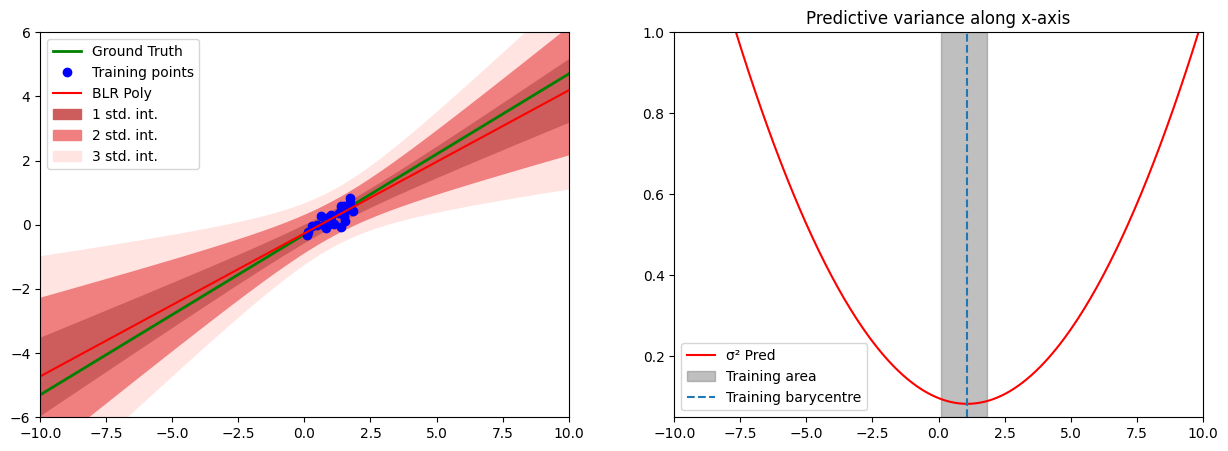

In [ ]:
# TO DO : predict on test dataset and visualize results

# You should use the following parameters for plot_results
# xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1
mean_pred, std_pred = f_pred(dataset_linear['X_test'])

plot_results(dataset_linear['X_train'], dataset_linear['y_train'],
             dataset_linear['X_test'], dataset_linear['y_test'],
             mean_pred, std_pred,
             xmin=-10, xmax=10, ymin=-6, ymax=6, stdmin=0.05, stdmax=1)

**Question 1.5: Analyse these results. Why predictive variance increases far from training distribution? Prove it analytically in the case where $\alpha=0$ and $\beta=1$.**

#### Analysis of results
The plot shows that within the training region (near the training points), the predictive variance is small, indicating high confidence in the model's predictions, while far from the training region (outside the range of the training points), the predictive varicance increases significantly, indicating that the model becomes less certain about its predictions.

This behavior is typical of Bayesian Linear Regression. Since the model relies on the training data to learn the posterior distribution of the weights, it becomes less confident in its predictions as the input moves away from the region where it has seen data.

#### 2. Analytical Proof (for $\alpha = 0$ and $\beta = 1$)

When $\alpha = 0$ and $\beta = 1$, the predictive variance formula simplifies significantly. Let’s derive it step by step:

---

**Predictive Variance Formula:**

For a test input $x^*$, the predictive variance is given by:

$$
\sigma_*^2 = \frac{1}{\beta} + \Phi_*^T \Sigma_N \Phi_*
$$

Since $\beta = 1$, this simplifies to:

$$
\sigma_*^2 = 1 + \Phi_*^T \Sigma_N \Phi_*
$$

---

**Posterior Covariance ($\Sigma_N$):**

The posterior covariance $\Sigma_N$ is given by:

$$
\Sigma_N = \left( \alpha I + \beta \Phi^T \Phi \right)^{-1}
$$

When $\alpha = 0$ and $\beta = 1$, this becomes:

$$
\Sigma_N = \left( \Phi^T \Phi \right)^{-1}
$$

---

**Design Matrix ($\Phi$):**

For a **linear basis function**, we have:

$$
\Phi =
\begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_N
\end{bmatrix}
$$

where $x_i$ are the training inputs.

---

**Variance Far from the Training Region:**

Consider a test input $x^*$ that is **far from the training points**. In this case, $\Phi_* = [1, x^*]^T$ (the basis function for $x^*$).

The term $\Phi_*^T \Sigma_N \Phi_*$ grows quadratically with $x^*$ because:

1. **$\Phi^T \Phi$ is dominated by the $x_i^2$ terms for large $x_i$.**
2. **The inverse $(\Phi^T \Phi)^{-1}$ becomes small in magnitude for large $x_i$, but $\Phi_*^T \Phi_*$ grows as $x^{*2}$.**

Thus, the predictive variance increases **quadratically** with the distance from the training region.

**Bonus Question: What happens when applying Bayesian Linear Regression on the following dataset?**

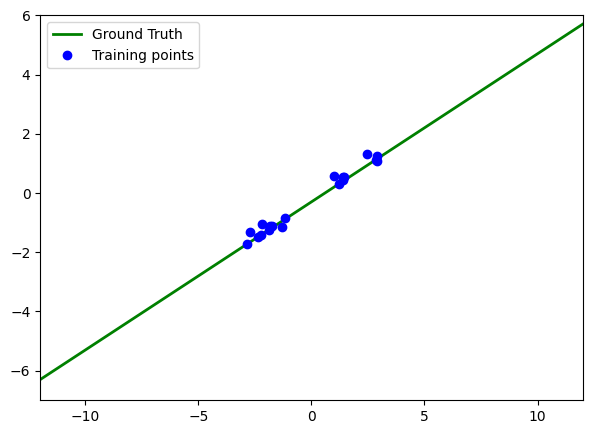

In [ ]:
# Create training and test points
sigma = 0.2
dataset_hole = {}
dataset_hole['X_train'] = np.concatenate(([np.random.uniform(-3, -1, 10), np.random.uniform(1, 3, 10)]), axis=0)
dataset_hole['y_train'] = f_linear(dataset_hole['X_train'], noise_amount=1,sigma=sigma)
dataset_hole['X_test'] = np.linspace(-12,12, 100)
dataset_hole['y_test'] = f_linear(dataset_hole['X_test'], noise_amount=0,sigma=sigma)
dataset_hole['ALPHA'] = 2.0
dataset_hole['BETA'] = 1/(2.0*sigma**2)

# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-12, xmax = 12)
plt.ylim(ymin = -7, ymax = 6)
plt.plot(dataset_hole['X_test'], dataset_hole['y_test'], color='green', linewidth=2, label="Ground Truth")
plt.plot(dataset_hole['X_train'], dataset_hole['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

We expect to have high vairance in the interval [-1,1], since the model has not seen any data in that interval. In fact in this region the predictive mean might not mantch the ground truth well, as the model attempts to interpolate between the two disjoint training intervals.

On the other hand in the regions [-3,-1] and [1,3], since the model has seen data, the predictive variance should be low, indicating high confidence in its predictions.

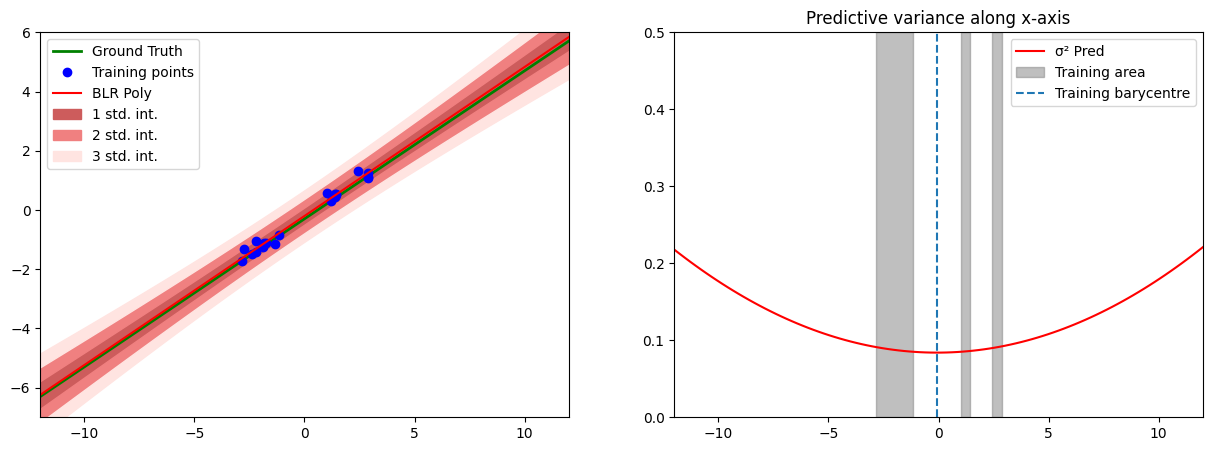

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5

f_pred = closed_form(phi_linear, dataset_hole['X_train'], dataset_hole['y_train'],
                     dataset_hole['ALPHA'], dataset_hole['BETA'])
mean_pred, std_pred = f_pred(dataset_hole['X_test'])
plot_results(dataset_hole['X_train'], dataset_hole['y_train'],
             dataset_hole['X_test'], dataset_hole['y_test'],
             mean_pred, std_pred,
             xmin=-12, xmax=12, ymin=-7, ymax=6, stdmin=0.0, stdmax=0.5)

##### Observations
The predictive mean (red line) closely follows the ground truth (green line) in the two regions where we have training data.

In the gap region, where no training data is available, the model interpolates linearly between the two disjoint training regions. However it doesn't perfectly match the ground truth in this gap due to lack of information. Anyway Bayesian Linear Regression models are smooth interpolators, meaning they attempt to connect nearby regions smoothly and, since the gap region is bounded by two relatively close intervals with low variance, the model "borrows confidence" from the nearby training regions, leading to lower variance in the gap.

Far from the training regions (beyond -3 and 3) the variance increases quadratically, which is typical for Bayesian Linear Regression.

The plot hence demonstrates the key properties of Bayesian Linear Regression:
- the model has high confidecne (low variance) in regions where training data is available;
- the variance increases in regions with sparse or no data, reflecting the model's uncertainty;
- the predictive variance increases quadratically as the model extrapolates far from the training region.

## Part II: Non Linear models

We now introduce a more complex toy dataset, which is an increasing sinusoidal curve. The goal of this part is to get insight on the importance of the chosen basis function on the predictive variance behavior.

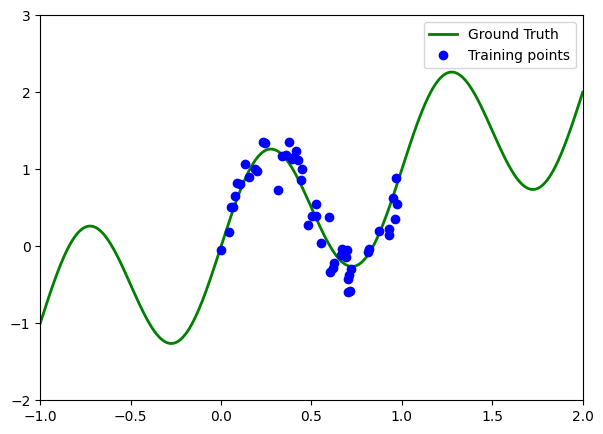

In [ ]:
# Generate sinusoidal toy dataset
def f_sinus(x, noise_amount,sigma=0.2):
    y = np.sin(2*np.pi*x) + x
    noise = np.random.normal(0, sigma, len(x))
    return y + noise_amount * noise

# Create training and test points
sigma=0.2
nbpts=50
dataset_sinus = {}
dataset_sinus['X_train'] = np.random.uniform(0, 1, nbpts)
dataset_sinus['y_train'] = f_sinus(dataset_sinus['X_train'], noise_amount=1,sigma=sigma)
dataset_sinus['X_test'] = np.linspace(-1,2, 10*nbpts)
dataset_sinus['y_test'] = f_sinus(dataset_sinus['X_test'], noise_amount=0,sigma=sigma)

dataset_sinus['ALPHA'] = 0.05
dataset_sinus['BETA'] = 1/(2.0*sigma**2)


# Plot dataset
plt.figure(figsize=(7,5))
plt.xlim(xmin =-1, xmax = 2)
plt.ylim(ymin = -2, ymax = 3)
plt.plot(dataset_sinus['X_test'], dataset_sinus['y_test'], color='green', linewidth=2,
         label="Ground Truth")
plt.plot(dataset_sinus['X_train'], dataset_sinus['y_train'], 'o', color='blue', label='Training points')
plt.legend()
plt.show()

### II.1 Polynomial basis functions

We will first use polynomial basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_{D-1})$$
where $\phi_j = x^j$ for $j \geq 0$ and $D \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    1 & x_1 & x_1^2 &... &x_1^{D-1} \\
    ... & ... & ... & ...\\
    1 & x_n & x_n^2 &... &x_n^{D-1}
  \end{bmatrix}
$$

**Question 2.1: Code polynomial basis function**

In [ ]:
# Define basis function
def phi_polynomial(x):
    """ Polynomial Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) polynomial features of x
    """
    D = 10

    return np.column_stack([x**i for i in range(D)])

**Question 2.2 : Code and visualize results on sinusoidal dataset using polynomial basis functions. What can you say about the predictive variance?**

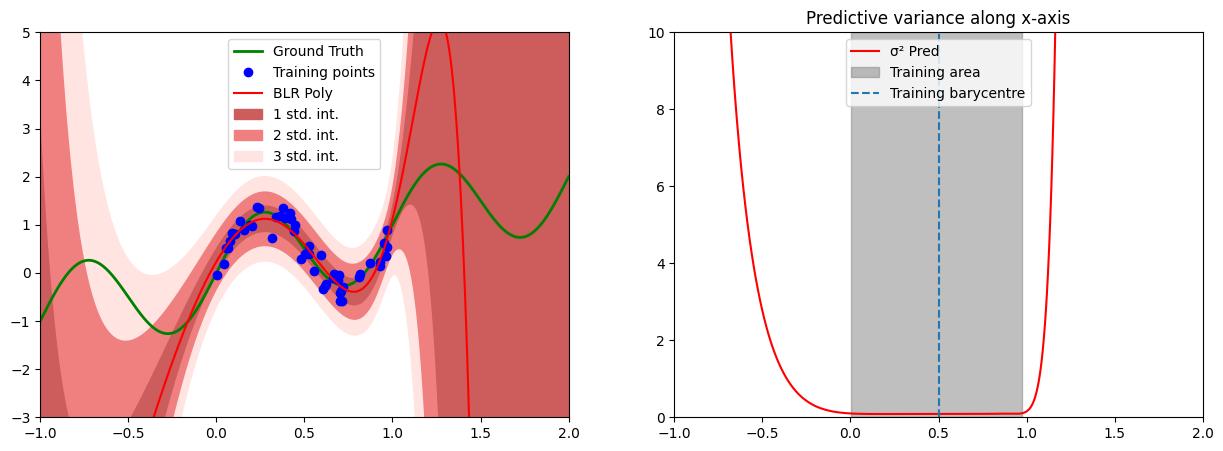

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0, stdmax=10

f_pred = closed_form(phi_polynomial, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

mean_pred, std_pred = f_pred(dataset_sinus['X_test'])

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'],
             dataset_sinus['X_test'], dataset_sinus['y_test'],
             mean_pred, std_pred,
             xmin=-1, xmax=2, ymin=-3, ymax=5, stdmin=0.0, stdmax=10)


##### Interpretation of predictive variance
Near the training points, the predictive variance (shown as shaded regions around the red line) is low, indicating high condfidence in the model's predictions. In this region in fact, the model has enough data to make confident predictions, so the variance is low.

Far from the training points (especially on the right side of the plot, where there are no training points), the variance increases significantly, reflecting the model's uncertainty as it extrapolates. As we move farther away from the training points (beyond the range [0,1]) the model starts to extrapolate, which inherently increases uncertainty.

Using polynomial basis functions increases the complexity of the model. While this can lead to a better fit within the training region, it can also amplify uncertainty outside the training region, especially when extrapolating.



### II.2 Gaussian basis functions

Now, let's consider gaussian basis functions:
$$\phi:x \rightarrow (\phi_0,\phi_1,...,\phi_M)$$
where $\phi_j = \exp \Big ( -\frac{(x-\mu_j)^2}{2s^2} \Big )$ for $j \geq 0$


Design matrix $\Phi$ defined on training set is:
$$ \Phi=
  \begin{bmatrix}
    \phi_0(x_1) & \phi_1(x_1) &... &\phi_M(x_1) \\
    ... & ... & ... & ...\\
    \phi_0(x_n) & \phi_1(x_n) &... &\phi_M(x_n)
  \end{bmatrix}
$$

**Question 2.3: Code gaussian basis function**

In [ ]:
#TO DO: Define Gaussian basis function
MU_MIN = 0
MU_MAX = 1
M = 9

def phi_gaussian(x) :
    """ Gaussian Basis Functions

    Args:
      x: (float) 1D input

    Returns:
      (array) gaussian features of x
    """
    s = (MU_MAX-MU_MIN)/M

    return np.array([np.exp(-(e - np.arange(MU_MIN, MU_MAX, s)) ** 2 / (2 * s * s)) for e in x])

**Question 2.4 : Code and visualize results on sinusoidal dataset using Gaussian basis functions. What can you say this time about the predictive variance?**

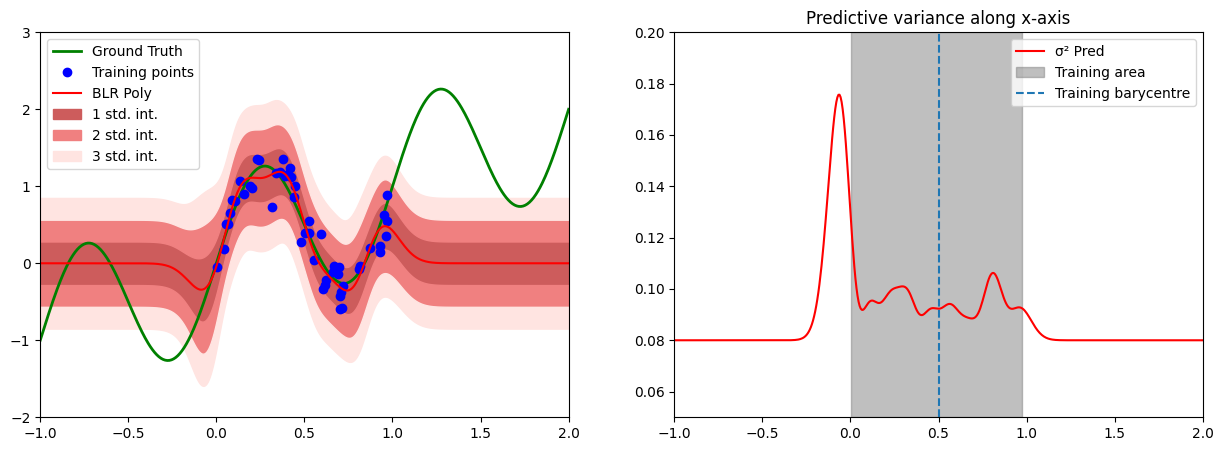

In [ ]:
# TO DO: Define f_pred, predict on test points and plot results

# You should use the following parameters for plot_results
# xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2

f_pred = closed_form(phi_gaussian, dataset_sinus['X_train'], dataset_sinus['y_train'],
                     dataset_sinus['ALPHA'], dataset_sinus['BETA'])

mean_pred, std_pred = f_pred(dataset_sinus['X_test'])

plot_results(dataset_sinus['X_train'], dataset_sinus['y_train'],
             dataset_sinus['X_test'], dataset_sinus['y_test'],
             mean_pred, std_pred,
             xmin=-1, xmax=2, ymin=-2, ymax=3, stdmin=0.05, stdmax=0.2)

##### Interpretation of predictive variance
From the left plot we can see that inside the range where training points are densely present, the model has low uncertainty (small predictive variance). This is indicated by the narrow shaded regions around the red curve. Inside the training region, the model has seen sufficient data, so it is confident in its predictions.

Beyond the range of training data (around $x < 0$ and $x > 1$), the model's predictive variance increases significantly because it lacks information in those regions. The shaded regions widen, and the variance plot on the right shows a noticeable rise. The lack of data in this case leads to greater uncertainty, and the model trusts its prior more, resulting in wider confidence intervals.
*****
**From the right plot**
For $x<0$ and $x>1$ the predictive variance remains nearly constant and low at around 0.08. This indicates that, although the model'uncertainty increases slightly, it remains relatively stable outside the training region.

There is a noticeable peak in the predictive variance just before $x=0$. This peak reflects the edge effect where fewer Gaussian basis function contribute, leading to slightly higher uncertainty.

Inside the training area the predictive variance fluctuates slightly but remains relatively low and stale, indicating the model's high confidence in this range where it has seen sufficient data.

This behavior could seem counterintuitive at first but it actually depends on the overlapping effects of Gaussian basis functions.
In fact in Bayesian linear regression with Gaussian basis functions, each basis function has a local influence around its mean. Inside the training region, multiple overlapping basis functions contribute to each prediction, creating a more complex model that tries to fit the data closely. This complexity leads to slightly higher uncertainty because the model needs to balance fitting noisy data points with its prior assumption (regularization). Therefore, even though the model is confident overall, there's some residual uncertainty due to noise and potential overfitting to the training data.

Outside the training region, the model extrapolates based primarily on its prior assumptions. Since there are fewer (or no) basis functions contributing in these regions, the predictions are driven by the mean of the prior, leading to more stable and lower predictive variance. In Bayesian regression the prior acts as a regularizer, preventing the model from being too uncertatin in regions where no data is present. This results in constant low variance outside the training area, rather than a sharp increase in uncertainty.

**Question 2.5: Explain why in regions far from training distribution, the predictive variance converges to this value when using localized basis functions such as Gaussians.**

Gaussian basis functions are localized, meaning that each basis function $\phi_j(x)$ has a strong influence only in a small region around tis center $\mu_j$. Far from the training distribution (where $x$ is far from all the $\mu_j$'s), the values of the Gaussian basis functions become very small (close to zero), meaning they contribute almost nothing to the predictions. Since the basis functions have minimal influence in these regions, the model essentially stops relying on the input $x$ and instead defaults to its prior assumptions.

******
Intuitively in regions far from the training data, the model has no information from the data to guide its predictions. As a result, the model defaults to relying on its prior belief about the noise level, leading to a constant predictive variance equal to the noise variance $\frac{1}{\beta}$. This behavir ensures that the model doesn't become overly confident in regions where it has no data, but it also prevent the variance from growing uncontrollably.

*****
#### Predictive variance

In Bayesian linear regression, the **predictive variance** is given by the following formula:
$$
\sigma^2_{\text{Pred}}(x) = \frac{1}{\beta} + \phi(x)^T S_N \phi(x)
$$

where:

- $\frac{1}{\beta}$ is the **variance of the noise**, which is a constant term representing the inherent noise in the observations.
- $\phi(x)$ is the **vector of Gaussian basis function values** at the input \(x\).
- $S_N$ is the **posterior covariance matrix** of the weights, which reflects the uncertainty in the model’s parameters after observing the training data.

---

#### **Far from the training distribution**:
- In regions far from the training points, the basis functions $\phi_j(x)$ have values close to zero because Gaussian basis functions are localized around their respective centers $\mu_j$.
- Consequently, the vector $\phi(x)$ becomes **almost zero**, and the second term $\phi(x)^T S_N \phi(x)$ becomes negligible.

Thus, the predictive variance simplifies to:
$$
\sigma^2_{\text{Pred}}(x) \approx \frac{1}{\beta}
$$
which is a **constant value equal to the noise variance**.
